# Questions and Answers Context Clusters Based Classification

<img src='https://miro.medium.com/max/1200/1*6ga054VrBMwLG4OC13bQoQ.png'>

<br />

Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

# Problem Formulation/Explanation

In this notebook, we try to classify the question and answer context based on clustering techniques that were applied to **SQuAD** dataset in advance.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.probability import FreqDist
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

sns.set()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Load Dataset

In [2]:
data = pd.read_csv("Q_A_label.csv")
data.head()

,Cluster,Unnamed: 0,title,context,question,id,answers,clean_context
0,0,0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,"{'answer_start': [515], 'text': ['Saint Bernad...",architectur school cathol charact atop main bu...
1,0,1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,"{'answer_start': [188], 'text': ['a copper sta...",architectur school cathol charact atop main bu...
2,0,2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,"{'answer_start': [279], 'text': ['the Main Bui...",architectur school cathol charact atop main bu...
3,0,3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,5733be284776f41900661181,"{'answer_start': [381], 'text': ['a Marian pla...",architectur school cathol charact atop main bu...
4,0,4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e,"{'answer_start': [92], 'text': ['a golden stat...",architectur school cathol charact atop main bu...


In [3]:
data.columns

Index(['Cluster', 'Unnamed: 0', 'title', 'context', 'question', 'id',
       'answers', 'clean_context'],
      dtype='object')

<hr />

As we see in above cell we have **context** and **clean_context** columns, we obtained **clean_context** column after we cleaned **context** column in **clustering** stage.

So, good news are we din't need to perform any cleaning preprocessing here.



In [4]:
data = data[['clean_context','Cluster']]

data.head()

,clean_context,Cluster
0,architectur school cathol charact atop main bu...,0
1,architectur school cathol charact atop main bu...,0
2,architectur school cathol charact atop main bu...,0
3,architectur school cathol charact atop main bu...,0
4,architectur school cathol charact atop main bu...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_context  5000 non-null   object
 1   Cluster        5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [6]:
data['Cluster'].value_counts()

0    4571
2     375
1      54
Name: Cluster, dtype: int64

In [7]:
data.shape

(5000, 2)

<hr />

# 2. Analysis and gain insights

<FreqDist with 53 samples and 72 outcomes>
[('seminari', 4), ('moreau', 3)]


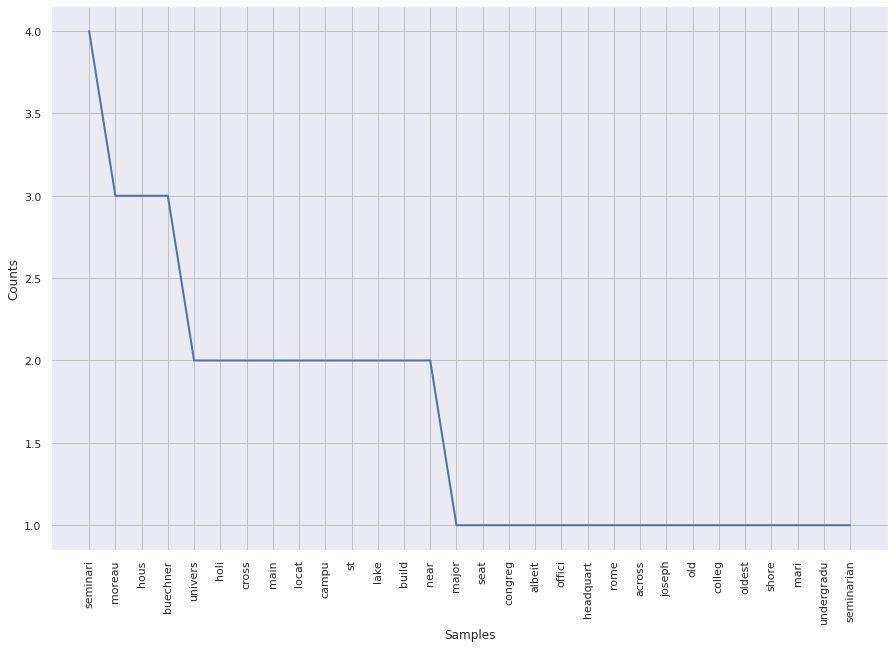

In [8]:
fdist = FreqDist(nltk.word_tokenize(data["clean_context"][10]))
print(fdist)
print(fdist.most_common(2))

plt.figure(figsize=(15,10))
fdist.plot(30,cumulative=False)
plt.show()

<hr />

## 2.1 Word Cloud

<img src='https://theappassembly.com/wp-content/uploads/2016/11/BigDataWordMap-1264x736.jpg'>

<br />

Now let's draw a wordcloud fo each book.

wordcloud consider a visual representations of words that give greater prominence to words that appear more frequently in doucument

In [9]:
from wordcloud import WordCloud, STOPWORDS
def worldcloud(df):
  comment_words = ''
  stopwords = set(STOPWORDS)
  
  # iterate through the csv file
  for val in df:
      
      # typecaste each val to string
      val = str(val)
  
      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)
  
  # plot the WordCloud image                      
  plt.figure(figsize=(15,10), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()

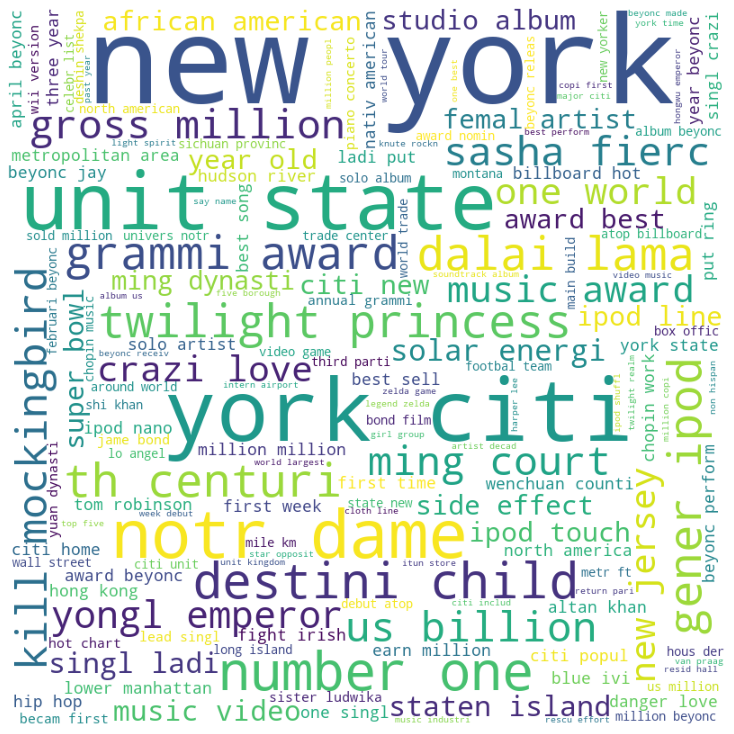

In [10]:
worldcloud(data['clean_context'])

<hr />

# 3. Data preparation

Now we will prepare our data to be ready to feed into machine learning models

## 3.1 Create Bag of Words

<img src='https://busyteacher.org/uploads/posts/2015-02/1424326564_bag-basic-english-words-0.png'>

<br />

In [11]:
X = data['clean_context'].values
y = data['Cluster']

In [12]:
counVec = CountVectorizer()
X_bow = counVec.fit_transform(X).toarray()

X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
X_bow_df = pd.DataFrame(X_bow,columns=counVec.get_feature_names())
X_bow_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aac,aaliyah,aaron,abandon,abbot,abbrevi,abc,abdomen,abduct,abel,...,zoo,zoologist,zora,zorn,zu,zuccotti,zuma,zuoren,zverev,zywni
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<hr />

## 3.2 Create TF-IDF

<img src='https://miro.medium.com/max/1200/1*qQgnyPLDIkUmeZKN2_ZWbQ.png'>

<br />


In [14]:
tfidfVec = TfidfVectorizer()
X_tf_idf = tfidfVec.fit_transform(X).toarray()

X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
X_tfidf_df = pd.DataFrame(X_tf_idf, columns=tfidfVec.get_feature_names())
X_tfidf_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aac,aaliyah,aaron,abandon,abbot,abbrevi,abc,abdomen,abduct,abel,...,zoo,zoologist,zora,zorn,zu,zuccotti,zuma,zuoren,zverev,zywni
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr />

# 4. Data Spliting

<img src='https://files.realpython.com/media/Splitting-Datasets-With-sklearns-train_test_split_Watermarked.13dcac93b15d.jpg'>

<br />

In [16]:
bow_combined_data = pd.concat([X_bow_df, y], axis=1)
bow_combined_data

,aac,aaliyah,aaron,abandon,abbot,abbrevi,abc,abdomen,abduct,abel,...,zoologist,zora,zorn,zu,zuccotti,zuma,zuoren,zverev,zywni,Cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
tfidf_combined_data = pd.concat([X_tfidf_df, y], axis=1)
tfidf_combined_data

,aac,aaliyah,aaron,abandon,abbot,abbrevi,abc,abdomen,abduct,abel,...,zoologist,zora,zorn,zu,zuccotti,zuma,zuoren,zverev,zywni,Cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
training_set, testing_set = train_test_split(data, test_size=0.20, random_state=42, stratify=data['Cluster'])

In [19]:
bow_training_set, bow_testing_set = train_test_split(bow_combined_data, test_size=0.20, random_state=42, stratify=data['Cluster'])

print("BOW Training set shape = ", bow_training_set.shape)
print("-"*50)
print("BOW Testing set shape = ", bow_testing_set.shape)

BOW Training set shape =  (4000, 8509)
--------------------------------------------------
BOW Testing set shape =  (1000, 8509)


In [20]:
X_bow_train = bow_training_set.drop('Cluster', axis=1)
y_bow_train = bow_training_set['Cluster']

X_bow_test = bow_testing_set.drop('Cluster', axis=1)
y_bow_test = bow_testing_set['Cluster']

In [21]:
tfidf_training_set, tfidf_testing_set = train_test_split(tfidf_combined_data, test_size=0.20, random_state=42, stratify=data['Cluster'])

print("TF-IDF Training set shape = ", tfidf_training_set.shape)
print("-"*50)
print("TF-IDF Testing set shape = ", tfidf_testing_set.shape)

TF-IDF Training set shape =  (4000, 8509)
--------------------------------------------------
TF-IDF Testing set shape =  (1000, 8509)


In [22]:
X_tfidf_train = tfidf_training_set.drop('Cluster', axis=1)
y_tfidf_train = tfidf_training_set['Cluster']

X_tfidf_test = tfidf_testing_set.drop('Cluster', axis=1)
y_tfidf_test = tfidf_testing_set['Cluster']

In [23]:
print("X train rows based on BOW = ",X_bow_train.shape[0])
print("X test rows based on BOW = ",X_bow_test.shape[0])

print('-'*50)

print("X train rows based on TF-IDF = ",X_tfidf_train.shape[0])
print("X test rows based on TF-IDF = ",X_tfidf_test.shape[0])

X train rows based on BOW =  4000
X test rows based on BOW =  1000
--------------------------------------------------
X train rows based on TF-IDF =  4000
X test rows based on TF-IDF =  1000


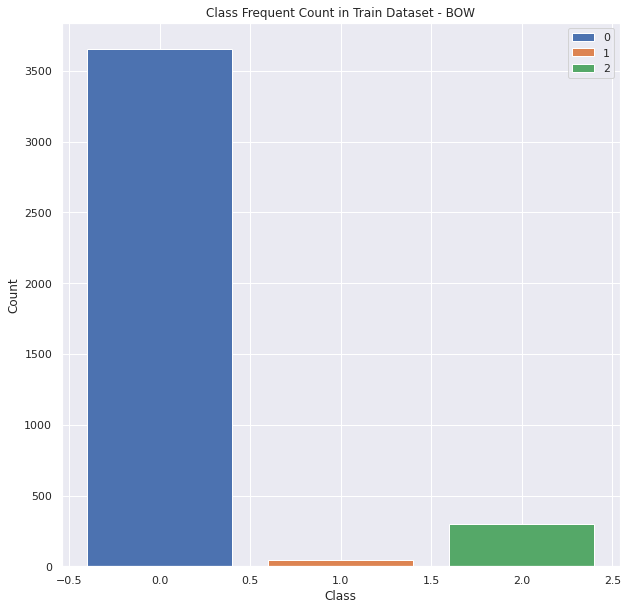

In [24]:
plt.figure(figsize=(10,10))

class_0 = list(y_bow_train.value_counts().index)[0]
class_2 = list(y_bow_train.value_counts().index)[1]
class_1 = list(y_bow_train.value_counts().index)[2]

class_0_count = list(y_bow_train.value_counts())[0]
class_2_count = list(y_bow_train.value_counts())[1]
class_1_count = list(y_bow_train.value_counts())[2]
               

plt.bar(class_0, class_0_count, label='0')
plt.bar(class_1, class_1_count, label='1')
plt.bar(class_2, class_2_count, label='2')

plt.title('Class Frequent Count in Train Dataset - BOW')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.show()

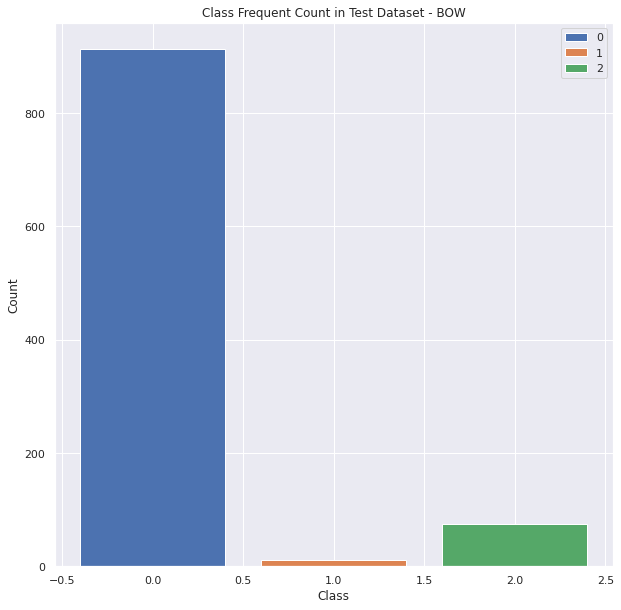

In [25]:
plt.figure(figsize=(10,10))

class_0 = list(y_bow_test.value_counts().index)[0]
class_2 = list(y_bow_test.value_counts().index)[1]
class_1 = list(y_bow_test.value_counts().index)[2]

class_0_count = list(y_bow_test.value_counts())[0]
class_2_count = list(y_bow_test.value_counts())[1]
class_1_count = list(y_bow_test.value_counts())[2]
               

plt.bar(class_0, class_0_count, label='0')
plt.bar(class_1, class_1_count, label='1')
plt.bar(class_2, class_2_count, label='2')

plt.title('Class Frequent Count in Test Dataset - BOW')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.show()

<hr />

**As we see in above 2 plots that the classes distrbution are the same in both train and test sets**

# 5.Models Bulding - BOW Approach

<img src='https://miro.medium.com/max/700/1*HgXA9v1EsqlrRDaC_iORhQ.png'>

<br />

Now we will build our classical models, we will use following models

* Decision Tree Classifier
* K - Nearest Neighbors Classifier
* Logistic Regression Classifier
* Support Vector Machine Classifier

## 5.1 Decision Tree Classifier

In [26]:
decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 3, 
                                           splitter='best', 
                                           random_state=42)

decisionTreeModel.fit(X_bow_train, y_bow_train)

print("decision Tree Classifier model trained successfully")

decision Tree Classifier model trained successfully


<hr /> 

### 5.1.1 Decision Tree Classifier Confusion Matrix

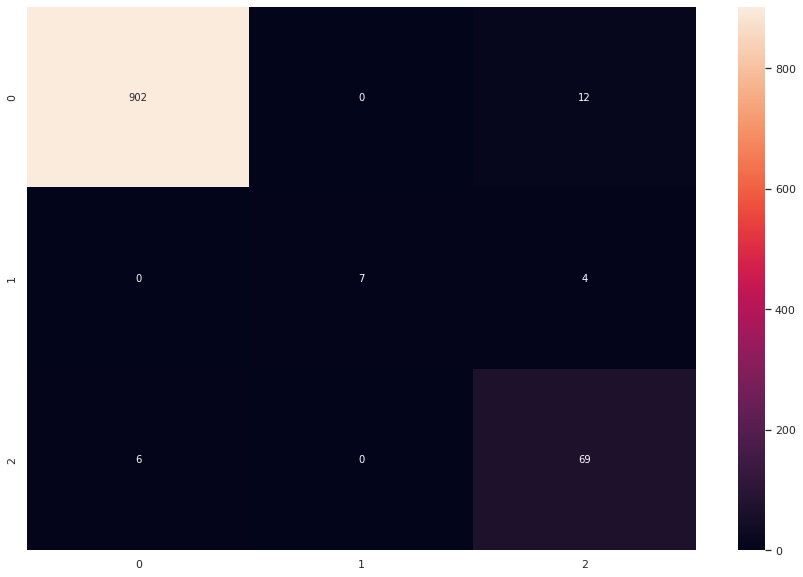

In [27]:
plt.figure(figsize=(15,10))
y_pred = decisionTreeModel.predict(X_bow_test)
sns.heatmap(confusion_matrix(y_bow_test, y_pred), annot=True, fmt='d')

<hr />

### 5.1.2 Decision Tree Classifier Kappa Score

In [28]:
kappa_score = cohen_kappa_score(bow_testing_set['Cluster'], y_pred)
kappa_score 

0.8655552567894595

<hr />

### 5.1.3 Decision Tree Classifier Error Analysis

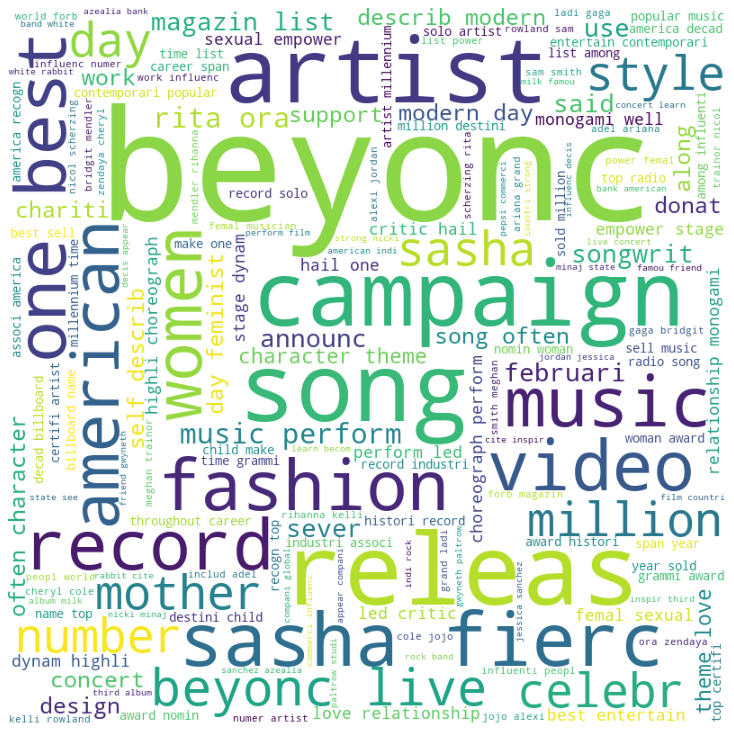

In [29]:
if kappa_score != 1:
  error_prediction = testing_set[bow_testing_set['Cluster'] != y_pred]

  error_text = error_prediction['clean_context']
  worldcloud(error_text)
else:
  print('We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0')  

<hr />

## 5.2 K-Nearest Neighbors Classifier


In [30]:
KNeighborsModel = KNeighborsClassifier(n_neighbors = 1)

KNeighborsModel.fit(X_bow_train, y_bow_train)

print("KNeighbors Classifier model trained successfully")

KNeighbors Classifier model trained successfully


<hr />

### 5.2.1 K-Nearest Neighbors Classifier Confusion Matrix

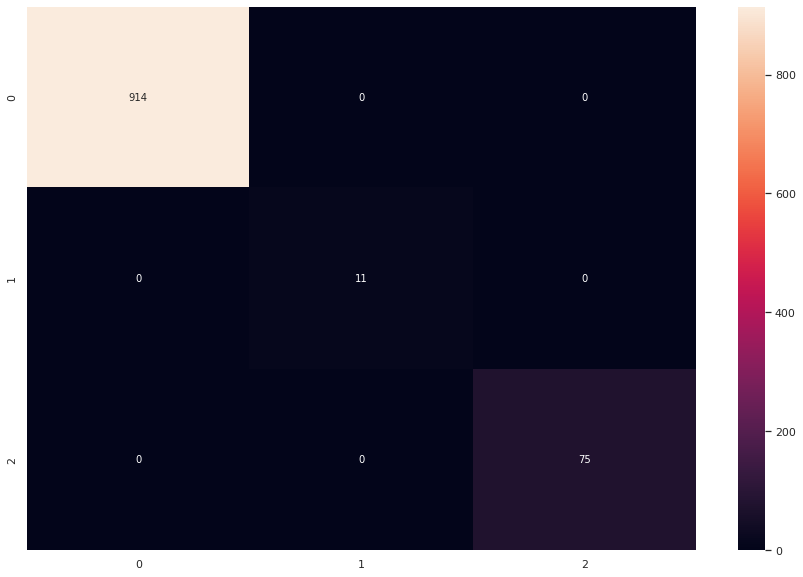

In [31]:
plt.figure(figsize=(15,10))
y_pred = KNeighborsModel.predict(X_bow_test)
sns.heatmap(confusion_matrix(y_bow_test, y_pred), annot=True, fmt='d')

<hr />

### 5.2.2 K-Nearest Neighbors Classifier Kappa Score

In [32]:
kappa_score = cohen_kappa_score(bow_testing_set['Cluster'], y_pred)
kappa_score 

1.0

<hr />

### 5.2.3 K-Nearest Neighbors Classifier Error Analysis

In [33]:
if kappa_score != 1:
  error_prediction = testing_set[bow_testing_set['Cluster'] != y_pred]

  error_text = error_prediction['clean_context']
  worldcloud(error_text)
else:
  print('We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0')  

We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0


<hr />

# 5.3 Logistic Regression Model

In [34]:
LogisticRegressionModel = LogisticRegression(penalty='l2',
                                        random_state = 42)  

LogisticRegressionModel.fit(X_bow_train, y_bow_train)

print("LogisticRegression Classifier model trained successfully")

LogisticRegression Classifier model trained successfully


<hr />

### 5.3.1 Logistic Regression Model Confusion Matrix

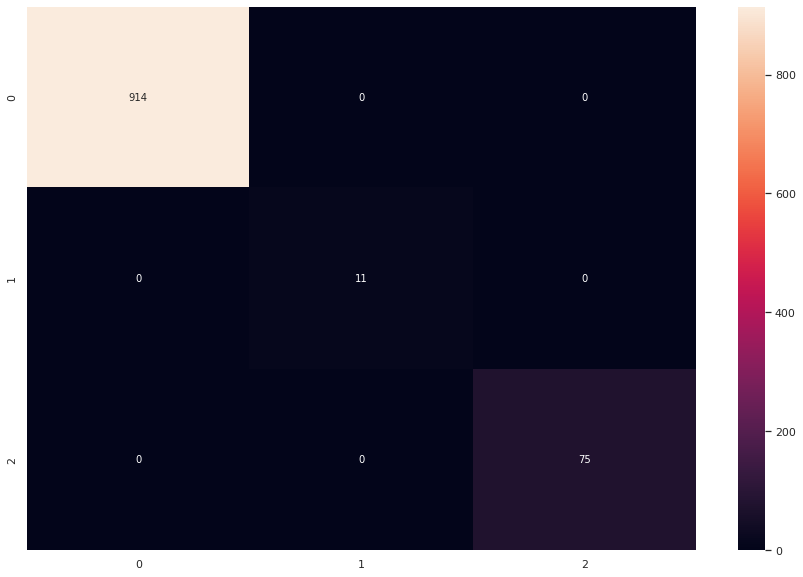

In [35]:
plt.figure(figsize=(15,10))
y_pred = LogisticRegressionModel.predict(X_bow_test)
sns.heatmap(confusion_matrix(y_bow_test, y_pred), annot=True, fmt='d')

<hr />

### 5.3.2 Logistic Regression Model Kappa Score

In [36]:
kappa_score = cohen_kappa_score(bow_testing_set['Cluster'], y_pred)
kappa_score 

1.0

<hr />

### 5.3.3 Logistic Regression Classifier Error Analysis

In [37]:
if kappa_score != 1:
  error_prediction = testing_set[bow_testing_set['Cluster'] != y_pred]

  error_text = error_prediction['clean_context']
  worldcloud(error_text)
else:
  print('We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0')  

We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0


<hr />

## 5.4 Support Vector Machine Model



In [38]:
SVClassifier = SVC(kernel= 'linear',
                   degree=3,
                   max_iter=10,
                   C=2, 
                   random_state = 42)

SVClassifier.fit(X_bow_train, y_bow_train)

print("SVClassifier model trained successfully")

SVClassifier model trained successfully


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


<hr />

### 5.4.1 SVC Model Confusion Matrix

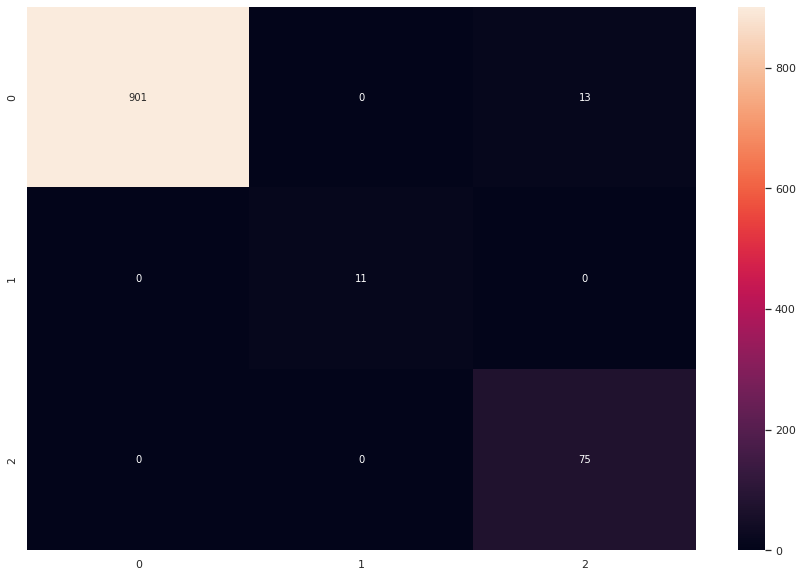

In [39]:
plt.figure(figsize=(15,10))
y_pred = SVClassifier.predict(X_bow_test)
sns.heatmap(confusion_matrix(y_bow_test, y_pred), annot=True, fmt='d')

<hr />

### 5.4.2 SVC Model Kappa Score

In [40]:
kappa_score = cohen_kappa_score(bow_testing_set['Cluster'], y_pred)
kappa_score 

0.9234235560922451

<hr />

### 5.4.2 SVC Model Error Analysis

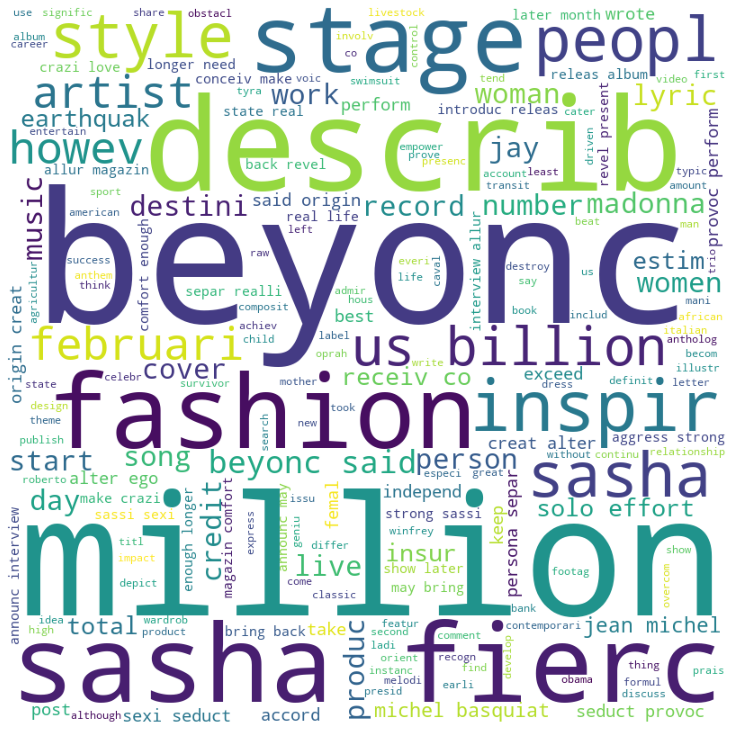

In [41]:
if kappa_score != 1:
  error_prediction = testing_set[bow_testing_set['Cluster'] != y_pred]

  error_text = error_prediction['clean_context']
  worldcloud(error_text)
else:
  print('We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0')  

<hr />

# 6. Models Evaluation - BOW Approach
 
 <img src='https://miro.medium.com/max/1200/1*59SfOBEuJ3m0KC7r5SshBQ.png'>

<br />

In [42]:
models = [decisionTreeModel, KNeighborsModel, SVClassifier, LogisticRegressionModel]
bow_overall_performance = {}

for model in models:
    print(type(model).__name__,' Train Score is   : ' ,model.score(X_bow_train, y_bow_train))
    print(type(model).__name__,' Test Score is    : ' ,model.score(X_bow_test, y_bow_test))
    
    y_pred = model.predict(X_bow_test)
    print(type(model).__name__,' Precision Score is      : ' ,precision_score(y_bow_test,y_pred, average='micro'))
    print(type(model).__name__,' Recall Score is      : ' ,recall_score(y_bow_test,y_pred, average='micro'))
    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_bow_test,y_pred, average='micro'))

    bow_overall_performance[type(model).__name__] = f1_score(y_bow_test,y_pred, average='micro')
    print('--------------------------------------------------------------------------')

DecisionTreeClassifier  Train Score is   :  0.9805
DecisionTreeClassifier  Test Score is    :  0.978
DecisionTreeClassifier  Precision Score is      :  0.978
DecisionTreeClassifier  Recall Score is      :  0.978
DecisionTreeClassifier  F1 Score is      :  0.978
--------------------------------------------------------------------------
KNeighborsClassifier  Train Score is   :  1.0
KNeighborsClassifier  Test Score is    :  1.0
KNeighborsClassifier  Precision Score is      :  1.0
KNeighborsClassifier  Recall Score is      :  1.0
KNeighborsClassifier  F1 Score is      :  1.0
--------------------------------------------------------------------------
SVC  Train Score is   :  0.98525
SVC  Test Score is    :  0.987
SVC  Precision Score is      :  0.987
SVC  Recall Score is      :  0.987
SVC  F1 Score is      :  0.987
--------------------------------------------------------------------------
LogisticRegression  Train Score is   :  1.0
LogisticRegression  Test Score is    :  1.0
LogisticRegressi

<hr />

# 6.Models Bulding - TF-IDF Approach

<img src='https://miro.medium.com/max/700/1*HgXA9v1EsqlrRDaC_iORhQ.png'>

<br />

Now we will build our classical models, we will use following models

* Decision Tree Classifier
* K - Nearest Neighbors Classifier
* Logistic Regression Classifier
* Support Vector Machine Classifier

## 6.1 Decision Tree Classifier

In [43]:
decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 3, 
                                           splitter='best', 
                                           random_state=42)

decisionTreeModel.fit(X_tfidf_train, y_tfidf_train)

print("decision Tree Classifier model trained successfully")

decision Tree Classifier model trained successfully


<hr /> 

### 6.1.1 Decision Tree Classifier Confusion Matrix

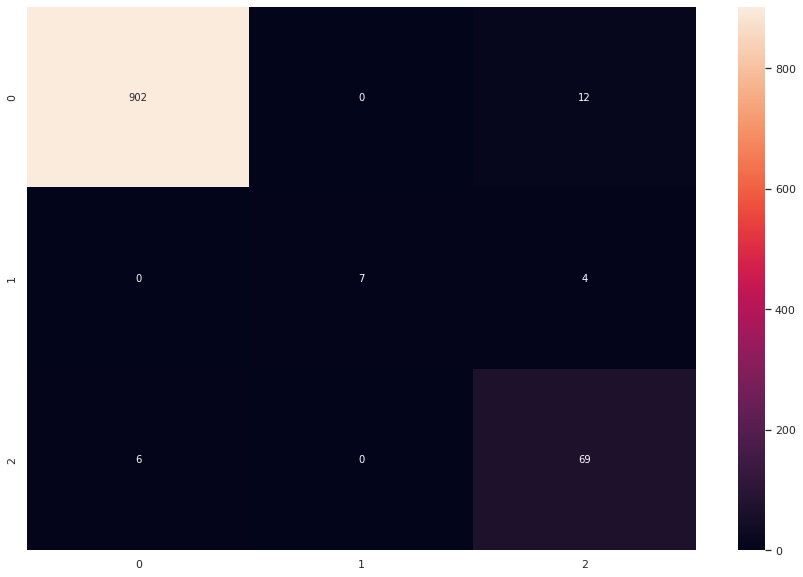

In [44]:
plt.figure(figsize=(15,10))
y_pred = decisionTreeModel.predict(X_tfidf_test)
sns.heatmap(confusion_matrix(y_tfidf_test, y_pred), annot=True, fmt='d')

<hr />

### 6.1.2 Decision Tree Classifier Kappa Score

In [45]:
kappa_score = cohen_kappa_score(tfidf_testing_set['Cluster'], y_pred)
kappa_score 

0.8655552567894595

<hr />

### 6.1.3 Decision Tree Classifier Error Analysis

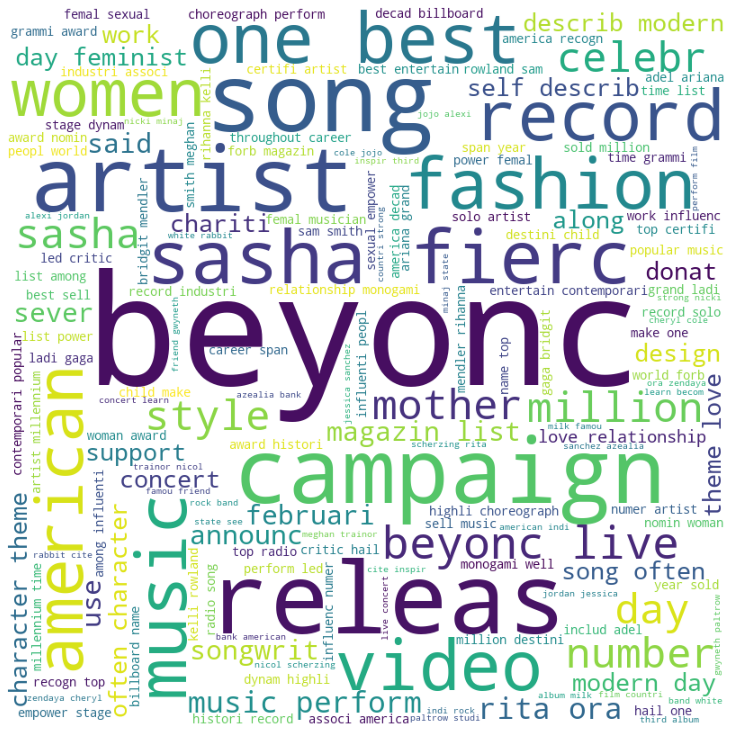

In [46]:
if kappa_score != 1:
  error_prediction = testing_set[tfidf_testing_set['Cluster'] != y_pred]

  error_text = error_prediction['clean_context']
  worldcloud(error_text)
else:
  print('We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0')  

<hr />

## 6.2 K-Nearest Neighbors Classifier


In [47]:
KNeighborsModel = KNeighborsClassifier(n_neighbors = 1)

KNeighborsModel.fit(X_tfidf_train, y_tfidf_train)

print("KNeighbors Classifier model trained successfully")

KNeighbors Classifier model trained successfully


<hr />

### 6.2.1 K-Nearest Neighbors Classifier Confusion Matrix

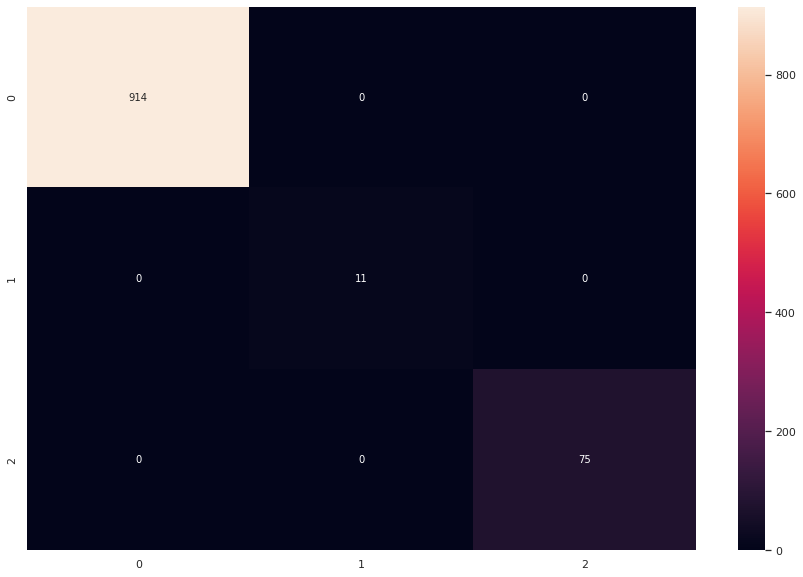

In [48]:
plt.figure(figsize=(15,10))
y_pred = KNeighborsModel.predict(X_tfidf_test)
sns.heatmap(confusion_matrix(y_tfidf_test, y_pred), annot=True, fmt='d')

<hr />

### 6.2.2 K-Nearest Neighbors Classifier Kappa Score

In [49]:
kappa_score = cohen_kappa_score(tfidf_testing_set['Cluster'], y_pred)
kappa_score 

1.0

<hr />

### 6.2.3 K-Nearest Neighbors Classifier Error Analysis

In [50]:
if kappa_score != 1:
  error_prediction = testing_set[tfidf_testing_set['Cluster'] != y_pred]

  error_text = error_prediction['clean_context']
  worldcloud(error_text)
else:
  print('We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0')  

We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0


## 6.3  Logistic Regression Model

In [51]:
LogisticRegressionModel = LogisticRegression(penalty='l2',
                                        random_state = 42)  

LogisticRegressionModel.fit(X_tfidf_train, y_tfidf_train)

print("LogisticRegression Classifier model trained successfully")

LogisticRegression Classifier model trained successfully


### 6.3.1 Logistic Regression Model Confusion Matrix

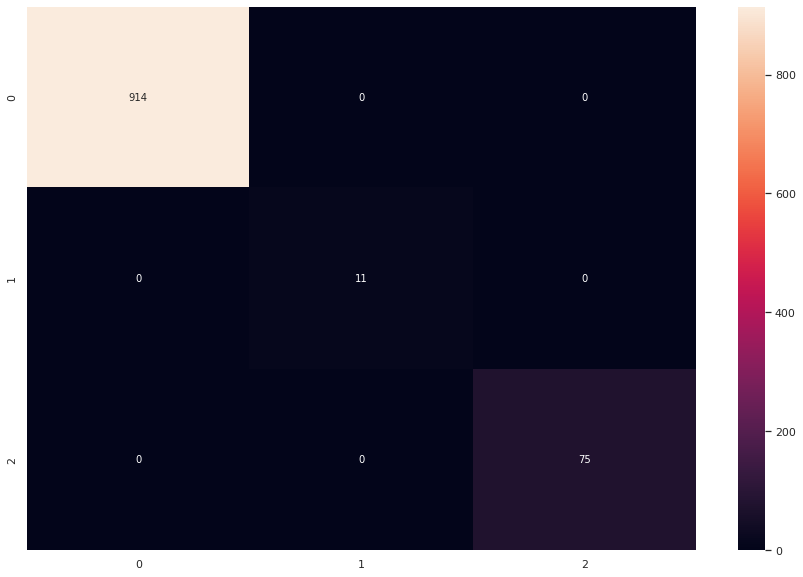

In [52]:
plt.figure(figsize=(15,10))
y_pred = LogisticRegressionModel.predict(X_tfidf_test)
sns.heatmap(confusion_matrix(y_tfidf_test, y_pred), annot=True, fmt='d')

<hr />

### 6.3.2 Logistic Regression Model Kappa Score

In [53]:
kappa_score = cohen_kappa_score(tfidf_testing_set['Cluster'], y_pred)
kappa_score 

1.0

<hr />

### 6.3.3 Logistic Regression Model Error Analysis

In [54]:
if kappa_score != 1:
  error_prediction = testing_set[tfidf_testing_set['Cluster'] != y_pred]

  error_text = error_prediction['clean_context']
  worldcloud(error_text)
else:
  print('We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0')  

We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0


<hr />

## 6.4 Support Vector Machine Model



In [55]:
SVClassifier = SVC(kernel= 'linear',
                   degree=3,
                   max_iter=10,
                   C=2, 
                   random_state = 42)

SVClassifier.fit(X_tfidf_train, y_tfidf_train)

print("SVClassifier model trained successfully")

SVClassifier model trained successfully


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


<hr />

### 6.4.1 SVC Model Confusion Matrix

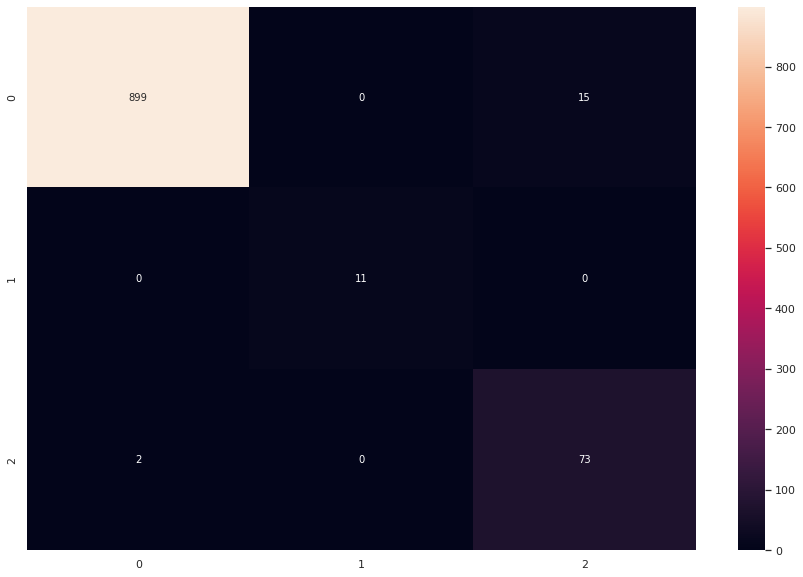

In [56]:
plt.figure(figsize=(15,10))
y_pred = SVClassifier.predict(X_tfidf_test)
sns.heatmap(confusion_matrix(y_tfidf_test, y_pred), annot=True, fmt='d')

<hr />

### 6.4.2 SVC Model Kappa Score

In [57]:
kappa_score = cohen_kappa_score(bow_testing_set['Cluster'], y_pred)
kappa_score 

0.8998615733513975

<hr />

### 6.4.2 SVC Model Error Analysis

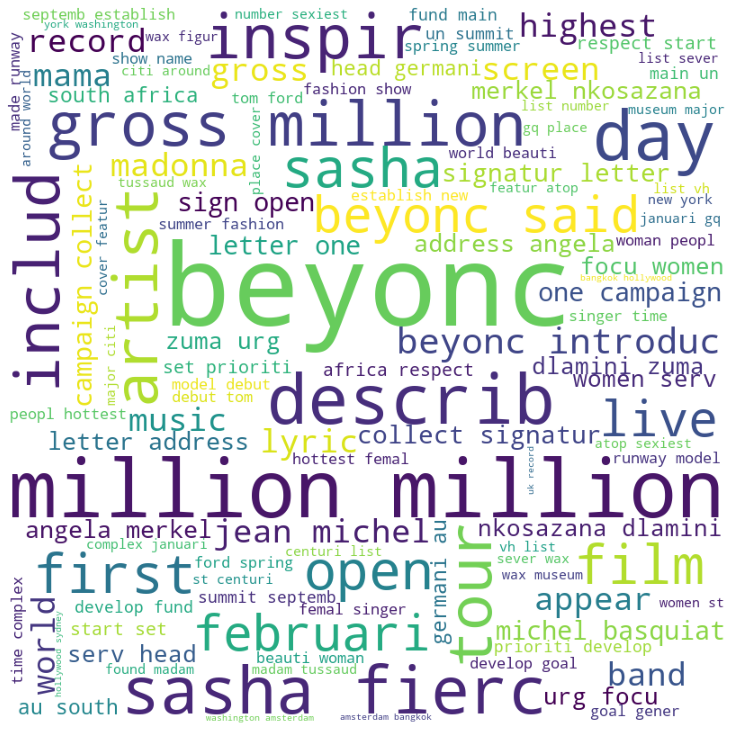

In [58]:
if kappa_score != 1:
  error_prediction = testing_set[tfidf_testing_set['Cluster'] != y_pred]

  error_text = error_prediction['clean_context']
  worldcloud(error_text)
else:
  print('We can not plot word cloud for wordes here becuse no error her, Kappa score = 1.0')  

<hr />

# 7. Models Evaluation - TF-IDF Approach
 
 <img src='https://miro.medium.com/max/1200/1*59SfOBEuJ3m0KC7r5SshBQ.png'>

<br />

In [59]:
models = [decisionTreeModel, KNeighborsModel, SVClassifier, LogisticRegressionModel]

tfidf_overall_performance = {}

for model in models:
    print(type(model).__name__,' Train Score is   : ' ,model.score(X_tfidf_train, y_tfidf_train))
    print(type(model).__name__,' Test Score is    : ' ,model.score(X_tfidf_test, y_tfidf_test))
    
    y_pred = model.predict(X_tfidf_test)
    print(type(model).__name__,' Precision Score is      : ' ,precision_score(y_tfidf_test,y_pred, average='micro'))
    print(type(model).__name__,' Recall Score is      : ' ,recall_score(y_tfidf_test,y_pred, average='micro'))
    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_tfidf_test,y_pred, average='micro'))

    tfidf_overall_performance[type(model).__name__] = f1_score(y_tfidf_test,y_pred, average='micro')
    print('--------------------------------------------------------------------------')

DecisionTreeClassifier  Train Score is   :  0.9805
DecisionTreeClassifier  Test Score is    :  0.978
DecisionTreeClassifier  Precision Score is      :  0.978
DecisionTreeClassifier  Recall Score is      :  0.978
DecisionTreeClassifier  F1 Score is      :  0.978
--------------------------------------------------------------------------
KNeighborsClassifier  Train Score is   :  1.0
KNeighborsClassifier  Test Score is    :  1.0
KNeighborsClassifier  Precision Score is      :  1.0
KNeighborsClassifier  Recall Score is      :  1.0
KNeighborsClassifier  F1 Score is      :  1.0
--------------------------------------------------------------------------
SVC  Train Score is   :  0.9715
SVC  Test Score is    :  0.983
SVC  Precision Score is      :  0.983
SVC  Recall Score is      :  0.983
SVC  F1 Score is      :  0.983
--------------------------------------------------------------------------
LogisticRegression  Train Score is   :  1.0
LogisticRegression  Test Score is    :  1.0
LogisticRegressio

<hr />

# 8. Performance Comparison - BOW Approach

In [60]:
bow_overall_performance_df = pd.DataFrame.from_dict(bow_overall_performance, orient='index', columns=['F1-Score'])

bow_overall_performance_df

,F1-Score
DecisionTreeClassifier,0.978
KNeighborsClassifier,1.000
SVC,0.987
LogisticRegression,1.000


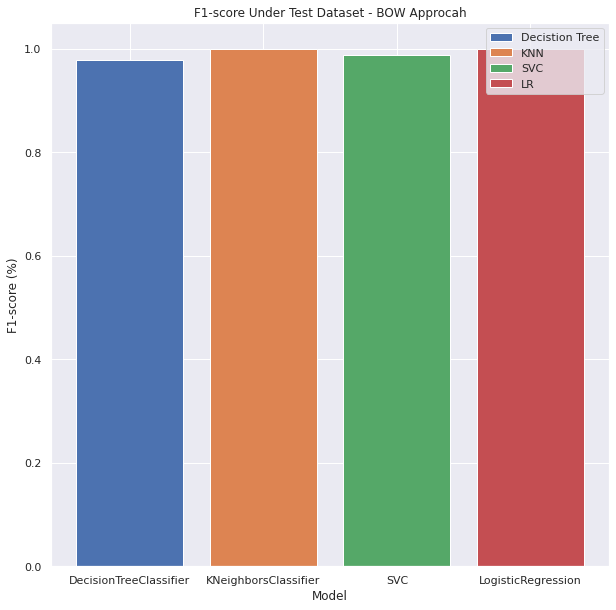

In [61]:
plt.figure(figsize=(10,10))
plt.bar('DecisionTreeClassifier', bow_overall_performance['DecisionTreeClassifier'], label='Decistion Tree')
plt.bar('KNeighborsClassifier', bow_overall_performance['KNeighborsClassifier'], label='KNN')
plt.bar('SVC', bow_overall_performance['SVC'], label='SVC')
plt.bar('LogisticRegression', bow_overall_performance['LogisticRegression'], label='LR')

plt.title('F1-score Under Test Dataset - BOW Approcah')
plt.xlabel('Model')
plt.ylabel('F1-score (%)')
plt.legend()
plt.show()

<hr />

# 9. Performance Comparison - TF-IDF Approach

In [62]:
tfidf_overall_performance_df = pd.DataFrame.from_dict(tfidf_overall_performance, orient='index', columns=['F1-Score'])

tfidf_overall_performance_df

,F1-Score
DecisionTreeClassifier,0.978
KNeighborsClassifier,1.000
SVC,0.983
LogisticRegression,1.000


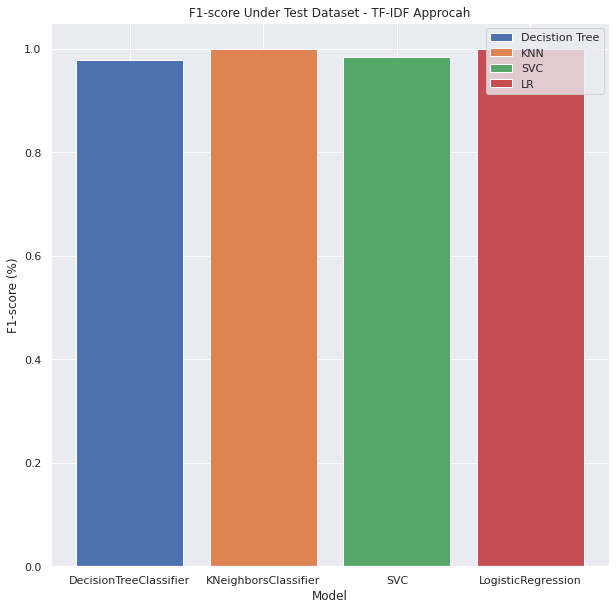

In [63]:
plt.figure(figsize=(10,10))
plt.bar('DecisionTreeClassifier', tfidf_overall_performance['DecisionTreeClassifier'], label='Decistion Tree')
plt.bar('KNeighborsClassifier', tfidf_overall_performance['KNeighborsClassifier'], label='KNN')
plt.bar('SVC', tfidf_overall_performance['SVC'], label='SVC')
plt.bar('LogisticRegression', tfidf_overall_performance['LogisticRegression'], label='LR')

plt.title('F1-score Under Test Dataset - TF-IDF Approcah')
plt.xlabel('Model')
plt.ylabel('F1-score (%)')
plt.legend()
plt.show()

# 10. Conclusion

 
 <img src='https://thumbs.dreamstime.com/b/writing-note-showing-conclusion-business-photo-showcasing-results-analysis-final-decision-end-event-process-writing-note-130549770.jpg'>

<br />

As we see in the above graphs of performance comparison, Both **Logistic Regression** and **KNN** models are the best models based on **F1-score** metrics using **BOW** or **TF-IDF** feature extraction approaches.